### The basics of neural circuit policies.

#### This notebook demonstrates building 3 recurrent neural networks based on the LTC model:
- A fully connected network.
- A sparse, randomly wired network
- A sparse, structured network based on the NCP principles.

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from kerasncp import wirings
from kerasncp.tf import LTCCell

2022-07-03 13:54:23.347947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-03 13:54:23.348017: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Generate sythetic sinusoidal training data.
N = 48 #Length of time series

#Input feature is a sine and cosine wave.
data_x = np.stack([
    np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis = 1)

data_x = np.expand_dims(data_x, axis = 0).astype(np.float32) #Add a batch dimension.

In [3]:
#Target output is a sine with double the frequency of the input signal.
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print(f'Feature set shape:  {data_x.shape}')
print(f'Target set shape: {data_y.shape}')

Feature set shape:  (1, 48, 2)
Target set shape: (1, 48, 1)


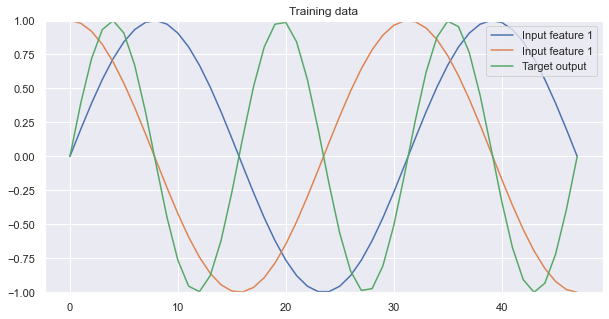

In [6]:
#Visualize the training data.
sns.set()
plt.figure(figsize = (10, 5))
plt.plot(data_x[0, :, 0], label = 'Input feature 1')
plt.plot(data_x[0, :, 1], label = 'Input feature 1')
plt.plot(data_y[0, :, 0], label = 'Target output')
plt.ylim((-1, 1))
plt.title('Training data')
plt.legend(loc = 'upper right')
plt.show()

## The LTC model.
The `keras-ncp` package is composed of 2 main parts:
- The LTC model.
- A wiring architecture for the cell above.

The wiring could be a `fully connected` or `sparsely` designed using the NCP princliples.

The LTC model is expressed in the form of a system of _ordinary differential equations in time._, any instance of it is inherently a recurrent neural network(RNN). 

That is why this example considers a sinusoidal time-series.

## 1. LTC model with fully connected wiring.

In [7]:
fc_wiring = wirings.FullyConnected(units = 8, output_dim = 1) # 8 units, 1 of which is a motor neuron.
ltc_cell = LTCCell(fc_wiring)

model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (None, 2)),
    keras.layers.RNN(ltc_cell, return_sequences = True)
])

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01),
             loss = 'mean_squared_error')

model.summary()

2022-07-03 14:12:56.819407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-03 14:12:56.819482: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-03 14:12:56.819537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debonair): /proc/driver/nvidia/version does not exist
2022-07-03 14:12:56.820998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, None, 1)           350       
                                                                 
Total params: 350
Trainable params: 350
Non-trainable params: 0
_________________________________________________________________


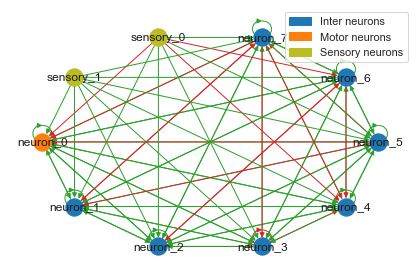

In [10]:
#Draw the wiring diagram of the model.
sns.set_style('white')
plt.figure(figsize = (6, 4))
legend_handles = ltc_cell.draw_graph(draw_labels = True)

plt.legend(handles = legend_handles, loc = 'upper right', bbox_to_anchor = (1, 1))
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.show()

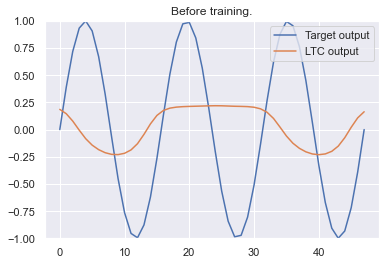

In [12]:
#Visualize the prediction of the network before training.
sns.set()
prediction = model(data_x).numpy()

plt.figure(figsize = (6, 4))
plt.plot(data_y[0, :,0], label = 'Target output')
plt.plot(prediction[0, :, 0], label = 'LTC output')
plt.ylim((-1, 1))
plt.title('Before training.')
plt.legend(loc = 'upper right')
plt.show()

In [13]:
#Train model for 400 epochs.
hist = model.fit(x = data_x, y = data_y, batch_size = 1, epochs = 400, verbose = 1)

Epoch 1/400
1/1 [==============================] - 6s 6s/step - loss: 0.4984
Epoch 2/400
1/1 [==============================] - 0s 90ms/step - loss: 0.4882
Epoch 3/400
1/1 [==============================] - 0s 79ms/step - loss: 0.4813
Epoch 4/400
1/1 [==============================] - 0s 68ms/step - loss: 0.4746
Epoch 5/400
1/1 [==============================] - 0s 68ms/step - loss: 0.4673
Epoch 6/400
1/1 [==============================] - 0s 74ms/step - loss: 0.4593
Epoch 7/400
1/1 [==============================] - 0s 70ms/step - loss: 0.4509
Epoch 8/400
1/1 [==============================] - 0s 70ms/step - loss: 0.4422
Epoch 9/400
1/1 [==============================] - 0s 72ms/step - loss: 0.4332
Epoch 10/400
1/1 [==============================] - 0s 75ms/step - loss: 0.4238
Epoch 11/400
1/1 [==============================] - 0s 70ms/step - loss: 0.4132
Epoch 12/400
1/1 [==============================] - 0s 76ms/step - loss: 0.4010
Epoch 13/400
1/1 [==============================] -

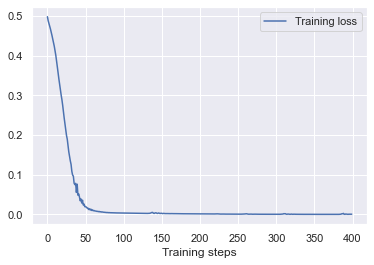

In [16]:
#Plot the training loss.
sns.set()
plt.figure(figsize = (6, 4))
plt.plot(hist.history['loss'], label = 'Training loss')
plt.legend(loc = 'upper right')
plt.xlabel('Training steps')
plt.show()

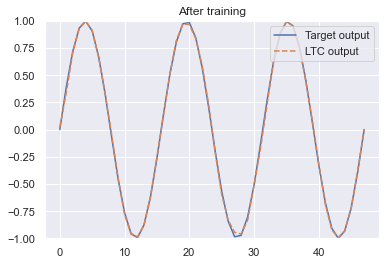

In [17]:
#Plot the prediction of the trained model.
prediction = model(data_x).numpy()

plt.figure(figsize = (6, 4))
plt.plot(data_y[0, :, 0], label = 'Target output')
plt.plot(prediction[0, :, 0], label = 'LTC output', linestyle = 'dashed')
plt.ylim((-1, 1))
plt.legend(loc = 'upper right')
plt.title('After training')
plt.show()

## 2. Random network with 75% sparsity.

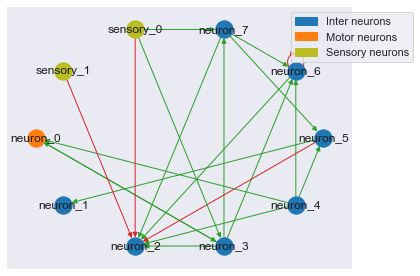

In [25]:
#Define LTC cell and wiring architecture.
rnd_wiring = wirings.Random(units = 8, output_dim = 1, sparsity_level = 0.75)
sparse_cell = LTCCell(rnd_wiring)

#Define keras model.
sparse_model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (None, 2)),
    keras.layers.RNN(sparse_cell, return_sequences = True)
])

sparse_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01), 
                    loss = 'mean_squared_error'
                    )

#PLot the wiring.
sns.set_style('dark')
plt.figure(figsize = (6, 4))
legend_handles = sparse_cell.draw_graph(draw_labels = True)

plt.legend(handles = legend_handles, loc = 'upper center', bbox_to_anchor = (1, 1))
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.show()

### Comparing random sparse vs fully connected networks.

In [26]:
hist_rand = sparse_model.fit(x = data_x, y = data_y, batch_size = 1, epochs = 400, verbose = 1)

Epoch 1/400
1/1 [==============================] - 5s 5s/step - loss: 0.7758
Epoch 2/400
1/1 [==============================] - 0s 82ms/step - loss: 0.6949
Epoch 3/400
1/1 [==============================] - 0s 79ms/step - loss: 0.6312
Epoch 4/400
1/1 [==============================] - 0s 72ms/step - loss: 0.5827
Epoch 5/400
1/1 [==============================] - 0s 89ms/step - loss: 0.5472
Epoch 6/400
1/1 [==============================] - 0s 159ms/step - loss: 0.5226
Epoch 7/400
1/1 [==============================] - 0s 156ms/step - loss: 0.5067
Epoch 8/400
1/1 [==============================] - 0s 157ms/step - loss: 0.4977
Epoch 9/400
1/1 [==============================] - 0s 161ms/step - loss: 0.4937
Epoch 10/400
1/1 [==============================] - 0s 165ms/step - loss: 0.4932
Epoch 11/400
1/1 [==============================] - 0s 152ms/step - loss: 0.4950
Epoch 12/400
1/1 [==============================] - 0s 150ms/step - loss: 0.4980
Epoch 13/400
1/1 [==========================

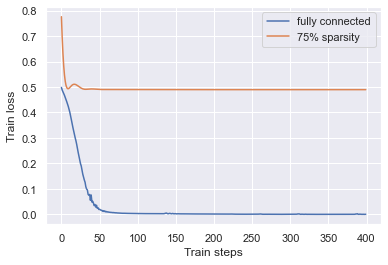

In [27]:
sns.set()
plt.figure(figsize = (6, 4))
plt.plot(hist.history['loss'], label = 'fully connected')
plt.plot(hist_rand.history['loss'], label = '75% sparsity')

plt.legend(loc = 'upper right')
plt.xlabel('Train steps')
plt.ylabel('Train loss')
plt.show()

## 3. Neural circuit policy wiring architecture.

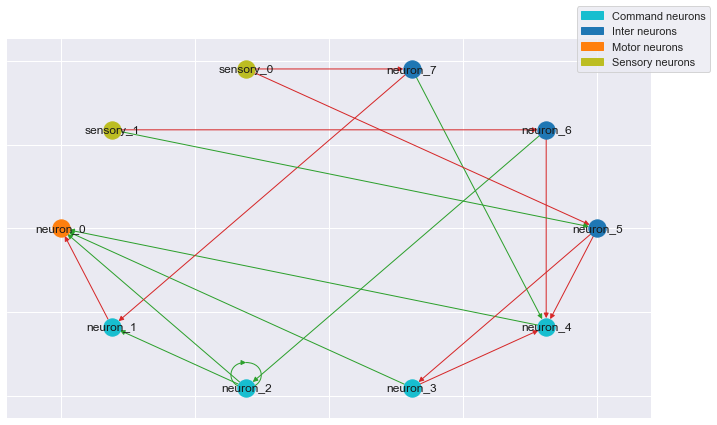

In [35]:
ncp_arch = wirings.NCP(inter_neurons = 3, #Number of inter neurons
                      command_neurons = 4, #Number of command neurons
                      motor_neurons = 1,  #Number of motor neurons
                      sensory_fanout = 2, #How many outgoing syapses has each sensory neuron
                      inter_fanout = 2, #Outgoing synapeses has each inter neuron
                      recurrent_command_synapses = 3, #Recurrent synapses in the command neuron layer
                      motor_fanin = 4 #How many incoming synapses has each motor neuron
                      )

ncp_cell = LTCCell(ncp_arch)

ncp_model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (None, 2)),
    keras.layers.RNN(ncp_cell, return_sequences = True)
])

ncp_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01),
                 loss = 'mean_squared_error')

sns.set_style('darkgrid')
plt.figure(figsize = (10, 6))
legend_handles = ncp_cell.draw_graph(draw_labels = True, neuron_colors = {'command': 'tab:cyan'})
plt.legend(handles = legend_handles, loc = 'upper right', bbox_to_anchor = (1.1, 1.1))
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.show()

In [36]:
hist_ncp = ncp_model.fit(x = data_x, y = data_y, batch_size = 1, 
                        epochs = 400, verbose = 1)

Epoch 1/400
1/1 [==============================] - 5s 5s/step - loss: 0.4927
Epoch 2/400
1/1 [==============================] - 0s 82ms/step - loss: 0.4912
Epoch 3/400
1/1 [==============================] - 0s 75ms/step - loss: 0.4902
Epoch 4/400
1/1 [==============================] - 0s 69ms/step - loss: 0.4895
Epoch 5/400
1/1 [==============================] - 0s 68ms/step - loss: 0.4891
Epoch 6/400
1/1 [==============================] - 0s 66ms/step - loss: 0.4891
Epoch 7/400
1/1 [==============================] - 0s 77ms/step - loss: 0.4890
Epoch 8/400
1/1 [==============================] - 0s 152ms/step - loss: 0.4888
Epoch 9/400
1/1 [==============================] - 0s 163ms/step - loss: 0.4885
Epoch 10/400
1/1 [==============================] - 0s 164ms/step - loss: 0.4883
Epoch 11/400
1/1 [==============================] - 0s 165ms/step - loss: 0.4882
Epoch 12/400
1/1 [==============================] - 0s 174ms/step - loss: 0.4879
Epoch 13/400
1/1 [============================

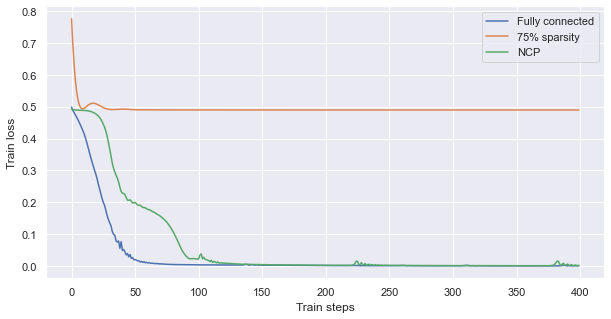

In [39]:
sns.set()
plt.figure(figsize = (10, 5))
plt.plot(hist.history['loss'], label = 'Fully connected')
plt.plot(hist_rand.history['loss'], label = '75% sparsity')
plt.plot(hist_ncp.history['loss'], label = 'NCP')

plt.legend(loc = 'upper right')
plt.xlabel('Train steps')
plt.ylabel('Train loss')
plt.show()

In [40]:
#Compute the sparsity of the NCP network.
sparsity = 1 - ncp_cell.synapse_count / ltc_cell.synapse_count

print('Sparsity level is: {:0.2f}%'.format(100 * sparsity))

Sparsity level is: 79.69%


### We see that the network with the NCP wiring architecture could fit the data as close as the fuly connected model.

#### The network with the NCP wiring performs as good as the fully-connected network but is even sparser than our random network tested above.